In [4]:
from sklearn.ensemble import IsolationForest

In [ ]:
pip install umap-learn hdbscan

In [11]:
pip install scikit-learn xgboost statsmodels


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 3.0 MB/s eta 0:00:49
   ---------------------------------------- 1.0/150.0 MB 1.7 MB/s eta 0:01:26
   ---------------------------------------- 1.6/150.0 MB 2.1 MB/s eta 0:01:11
    --------------------------------------- 2.1/150.0 MB 2.1 MB/s eta 0:01:09
    --------------------------------------- 2.4/150.0 MB 1.9 MB/s eta 0:01:18
    --------------------------------------- 2.6/150.0 MB 1.8 MB/s eta 0:01:24
    --------------------------------------- 3.1/150.0 MB 1.8 MB/s eta 0:01:22
    --------------------------------------- 3.7/150.0 MB 1.9 MB/s eta 0:01:17
   - -------------------------------------- 4.2/150.0 MB 1.9 MB/s eta 0:01:17
   - -------------------------------------- 5.0/150.0 MB 2.1 MB/s eta 0:01:10
   - -------------------------------------- 5.5/150.0 MB 2.1 MB/s eta 0:01:08


In [12]:
pip install pmdarima

     ---------------------------------------- 0.0/630.3 kB ? eta -:--:--
     ---------------- ----------------------- 262.1/630.3 kB ? eta -:--:--
     -------------------------------------- 630.3/630.3 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Error [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software while executing command pip subprocess to install build dependencies
ERROR: Could not install packages due to an OSError: [WinError 225] Operation did not complete successfully because the file contains a virus or potentially unwanted software


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Evaluation Results:
               Model           MAE          RMSE    MAPE (%)
0  Linear Regression  20634.852646  25654.337686  330.822373
1      Random Forest  19757.041578  25403.403591  309.062643
2            XGBoost  19541.086693  25487.614449  301.945321
3   Stacked Ensemble  19521.361811  25480.341862  301.291488
4     Naive Forecast  23306.005952  34215.639095  266.235208


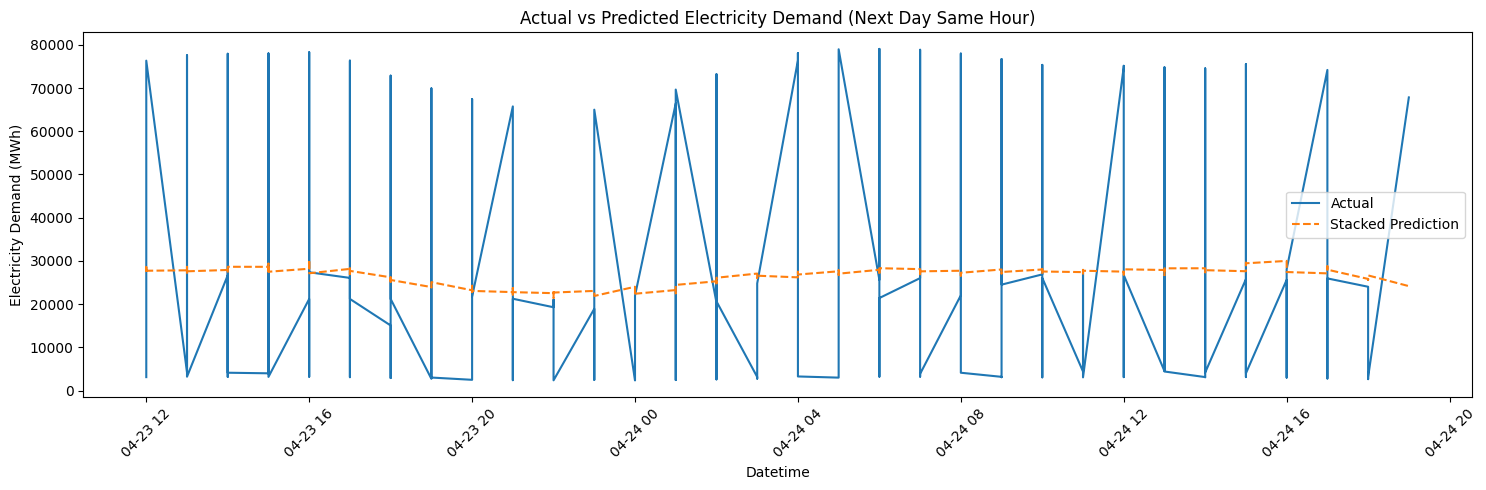

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load dataset and parse 'Timestamp'
df = pd.read_csv('C:/Users/SLS/Desktop/Electric/final_merged_weather_demand_dataset.csv', parse_dates=['Timestamp'])
df.sort_values('Timestamp', inplace=True)

# Rename columns for consistency
df.rename(columns={
    'Timestamp': 'datetime',
    'Electricity_Demand_MWh': 'demand',
    'windSpeed': 'wind_speed'
}, inplace=True)

# Feature engineering
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['prev_day_same_hour_demand'] = df['demand'].shift(24)  # Lag
df['target'] = df['demand'].shift(-24)  # 24h ahead

# Drop rows with NaNs
df.dropna(inplace=True)

# Features & target
feature_cols = ['temperature', 'humidity', 'wind_speed', 'hour', 'dayofweek', 'month', 'prev_day_same_hour_demand']
X = df[feature_cols]
y = df['target']

# Split train/test: last 7 days = test set
train_size = int(len(df) - 24 * 7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Baseline: naive forecast using previous day's demand
y_baseline = df['prev_day_same_hour_demand'][train_size:]
baseline_mae = mean_absolute_error(y_test, y_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
baseline_mape = np.mean(np.abs((y_test - y_baseline) / (y_test + 1e-6))) * 100  # Avoid zero division

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Random Forest with GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_rf = {'n_estimators': [100], 'max_depth': [5, 10]}
tscv = TimeSeriesSplit(n_splits=5)
grid_rf = GridSearchCV(rf, param_rf, cv=tscv, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# XGBoost with GridSearchCV
xgb = XGBRegressor(random_state=42)
param_xgb = {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
grid_xgb = GridSearchCV(xgb, param_xgb, cv=tscv, scoring='neg_mean_absolute_error')
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

# Stacking Ensemble
stack = StackingRegressor(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    final_estimator=LinearRegression(),
    passthrough=True
)
stack.fit(X_train, y_train)

# Evaluation function
def evaluate(model, name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-6))) * 100  # Safe MAPE
    return pd.Series({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape})

# Collect results
results = pd.concat([
    evaluate(lr, 'Linear Regression'),
    evaluate(best_rf, 'Random Forest'),
    evaluate(best_xgb, 'XGBoost'),
    evaluate(stack, 'Stacked Ensemble'),
    pd.Series({'Model': 'Naive Forecast', 'MAE': baseline_mae, 'RMSE': baseline_rmse, 'MAPE (%)': baseline_mape})
], axis=1).T.reset_index(drop=True)

print("\nEvaluation Results:")
print(results)

# Plot actual vs predicted using best model (stacked)
y_pred_stack = stack.predict(X_test)
plt.figure(figsize=(15, 5))
plt.plot(df['datetime'].iloc[train_size:], y_test.values, label='Actual')
plt.plot(df['datetime'].iloc[train_size:], y_pred_stack, label='Stacked Prediction', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Electricity Demand (MWh)')
plt.title('Actual vs Predicted Electricity Demand (Next Day Same Hour)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Evaluation Results:
               Model           MAE          RMSE    MAPE (%)
0  Linear Regression  20634.852646  25654.337686  330.822373
1      Random Forest  19757.041578  25403.403591  309.062643
2            XGBoost  19541.086693  25487.614449  301.945321
3   Stacked Ensemble  19521.361811  25480.341862  301.291488
4     Naive Forecast  23306.005952  34215.639095  266.235208


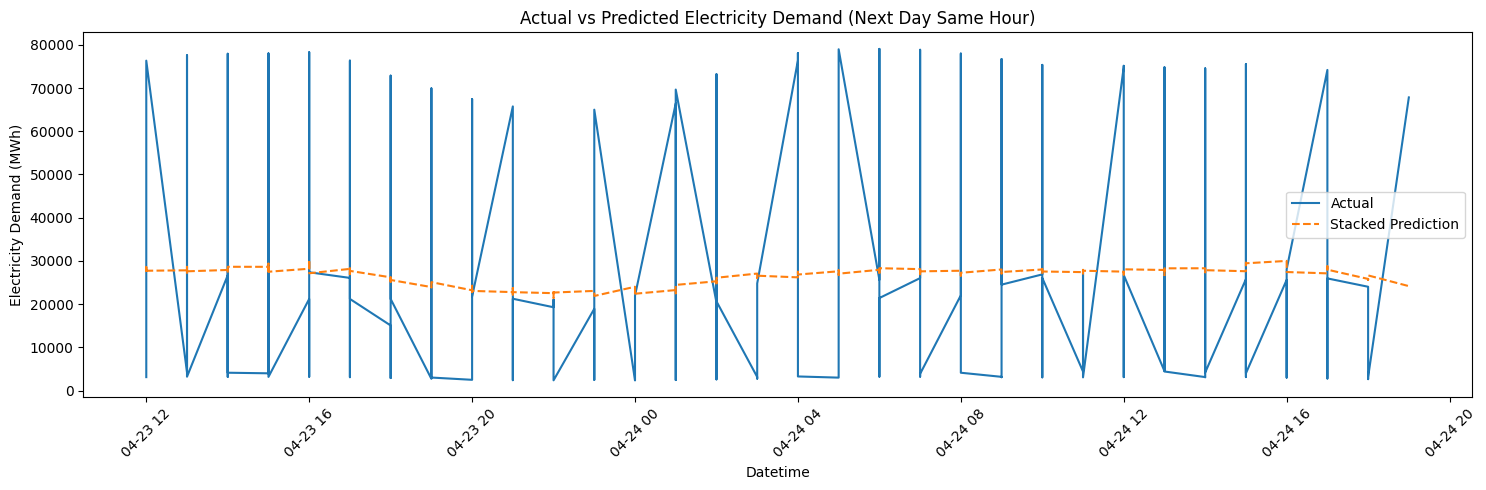

In [27]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load dataset and parse 'Timestamp'
df = pd.read_csv('C:/Users/SLS/Desktop/Electric/final_merged_weather_demand_dataset.csv', parse_dates=['Timestamp'])
df.sort_values('Timestamp', inplace=True)

# Rename columns for consistency
df.rename(columns={
    'Timestamp': 'datetime',
    'Electricity_Demand_MWh': 'demand',
    'windSpeed': 'wind_speed'
}, inplace=True)

# Feature engineering
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['prev_day_same_hour_demand'] = df['demand'].shift(24)  # Lag
df['target'] = df['demand'].shift(-24)  # 24h ahead

# Drop rows with NaNs
df.dropna(inplace=True)

# Features & target
feature_cols = ['temperature', 'humidity', 'wind_speed', 'hour', 'dayofweek', 'month', 'prev_day_same_hour_demand']
X = df[feature_cols]
y = df['target']

# Split train/test: last 7 days = test set
train_size = int(len(df) - 24 * 7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Baseline: naive forecast using previous day's demand
y_baseline = df['prev_day_same_hour_demand'][train_size:]
baseline_mae = mean_absolute_error(y_test, y_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
baseline_mape = np.mean(np.abs((y_test - y_baseline) / (y_test + 1e-6))) * 100  # Avoid zero division

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Random Forest with GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_rf = {'n_estimators': [100], 'max_depth': [5, 10]}
tscv = TimeSeriesSplit(n_splits=5)
grid_rf = GridSearchCV(rf, param_rf, cv=tscv, scoring='neg_mean_absolute_error')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# XGBoost with GridSearchCV
xgb = XGBRegressor(random_state=42)
param_xgb = {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.05, 0.1]}
grid_xgb = GridSearchCV(xgb, param_xgb, cv=tscv, scoring='neg_mean_absolute_error')
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

# Stacking Ensemble
stack = StackingRegressor(
    estimators=[('rf', best_rf), ('xgb', best_xgb)],
    final_estimator=LinearRegression(),
    passthrough=True
)
stack.fit(X_train, y_train)

# Evaluation function
def evaluate(model, name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-6))) * 100  # Safe MAPE
    return pd.Series({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape})

# Collect results
results = pd.concat([
    evaluate(lr, 'Linear Regression'),
    evaluate(best_rf, 'Random Forest'),
    evaluate(best_xgb, 'XGBoost'),
    evaluate(stack, 'Stacked Ensemble'),
    pd.Series({'Model': 'Naive Forecast', 'MAE': baseline_mae, 'RMSE': baseline_rmse, 'MAPE (%)': baseline_mape})
], axis=1).T.reset_index(drop=True)

print("\nEvaluation Results:")
print(results)

# Plot actual vs predicted using best model (stacked)
y_pred_stack = stack.predict(X_test)
plt.figure(figsize=(15, 5))
plt.plot(df['datetime'].iloc[train_size:], y_test.values, label='Actual')
plt.plot(df['datetime'].iloc[train_size:], y_pred_stack, label='Stacked Prediction', linestyle='--')
plt.xlabel('Datetime')
plt.ylabel('Electricity Demand (MWh)')
plt.title('Actual vs Predicted Electricity Demand (Next Day Same Hour)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
